## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","green"])

In [3]:
np.random.seed(0)

## Generate data

In [4]:
from sklearn.datasets import  make_circles

In [5]:
data, labels = make_circles(n_samples=1000, random_state=0, noise=0.2, factor=0.3)
print(data.shape, labels.shape)

(1000, 2) (1000,)


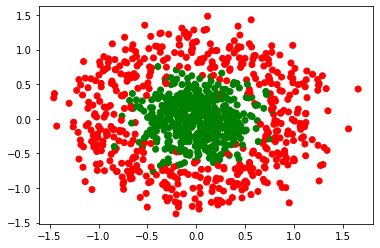

In [6]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [7]:
print("Data shape",data.shape)
print("Labels shape",labels.shape)

Data shape (1000, 2)
Labels shape (1000,)


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0,test_size=0.2)
print(X_train.shape, X_val.shape, labels.shape)

(800, 2) (200, 2) (1000,)


In [9]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(800, 2) (200, 2)


## FF Class

In [10]:
class FFNetwork:
  
  def __init__(self, num_hidden=2, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
        
    self.params={}
    self.num_layers=2
    self.layer_sizes = [2, num_hidden, 2]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    np.random.seed(0)
    
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
    
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      return (1-np.square(X))
    elif self.activation_function == "relu":
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
    
  def get_accuracy(self):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    return accuracy_train,accuracy_val
    
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 2) -> (N, 2)
    self.H2 = self.softmax(self.A2) # (N, 2)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD",l2_norm=False, lambda_val=0.8, display_loss=False, eta=1):
    train_accuracies={}
    val_accuracies={}
    if display_loss:
      loss = []
      weight_mag = []
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      self.grad(X, Y)
      for i in range(1,self.num_layers+1):
        if l2_norm:
          self.params["W"+str(i)] -= (eta * lambda_val)/m * self.params["W"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
        else:
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      train_accuracy,val_accuracy=self.get_accuracy()
      train_accuracies[num_epoch]=train_accuracy
      val_accuracies[num_epoch]=val_accuracy
      if display_loss:
        Y_pred = self.predict(X)
        loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
        weight_mag.append((norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"]))/18)
        
    plt.plot(train_accuracies.values(),label="Train accuracy")
    plt.plot(val_accuracies.values(),label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*0.33)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    if display_loss:
      fig, ax1 = plt.subplots()
      color = 'tab:red'
      ax1.set_xlabel('epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(loss, '-o', color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()  
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)  # we already handled the x-label with ax1
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout()  
      plt.show()

  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [11]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

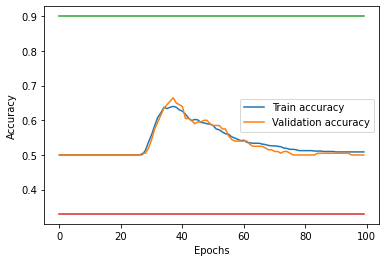

Training accuracy 0.5088
Validation accuracy 0.5


In [12]:
model = FFNetwork(num_hidden=1)
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

## All combination of activation function and weight initialization

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/10 [00:00<?, ?epoch/s]

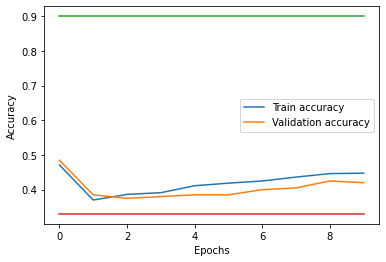

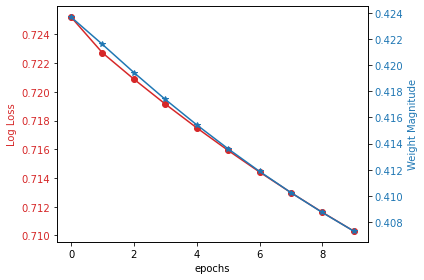

Training accuracy 0.4475
Validation accuracy 0.42


In [13]:
model = FFNetwork(init_method='random', activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=10, eta=1, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/10 [00:00<?, ?epoch/s]

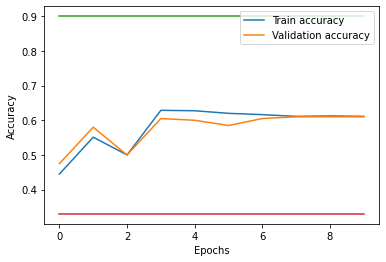

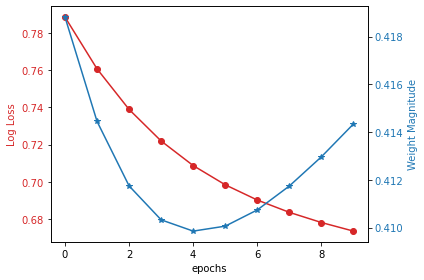

Training accuracy 0.6112
Validation accuracy 0.61


In [14]:
model = FFNetwork(init_method='random', activation_function='tanh')
model.fit(X_train, y_OH_train, epochs=10, eta=1, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/10 [00:00<?, ?epoch/s]

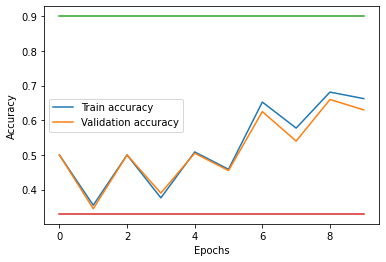

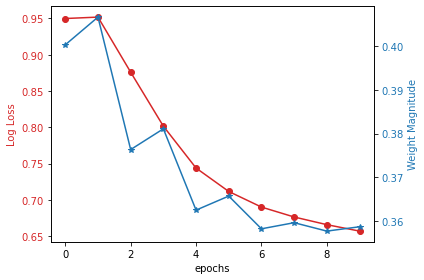

Training accuracy 0.6625
Validation accuracy 0.63


In [15]:
model = FFNetwork(init_method='random', activation_function='relu')
model.fit(X_train, y_OH_train, epochs=10, eta=1, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/10 [00:00<?, ?epoch/s]

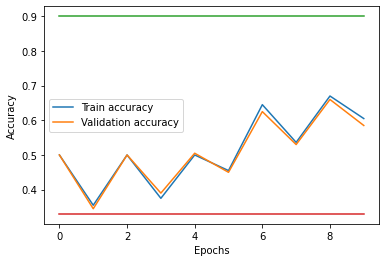

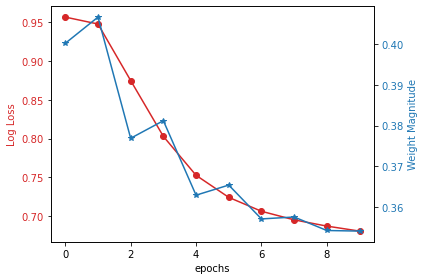

Training accuracy 0.605
Validation accuracy 0.585


In [16]:
model = FFNetwork(init_method='random', activation_function='leaky_relu')
model.fit(X_train, y_OH_train, epochs=10, eta=1, display_loss=True)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

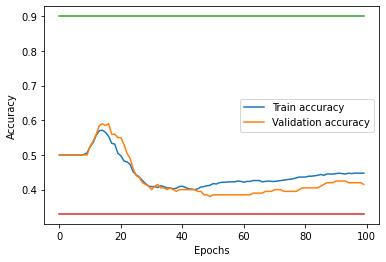

Training accuracy 0.4475
Validation accuracy 0.415


In [17]:
model = FFNetwork(init_method='he', activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

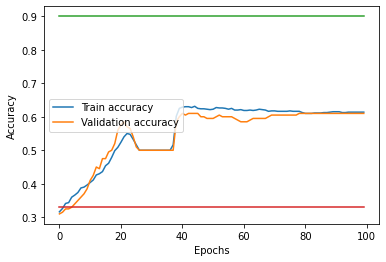

Training accuracy 0.6138
Validation accuracy 0.61


In [18]:
model = FFNetwork(init_method='he', activation_function='tanh')
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

## The combination of "he" with "relu" is giving highest accuracy so this is the best combination

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

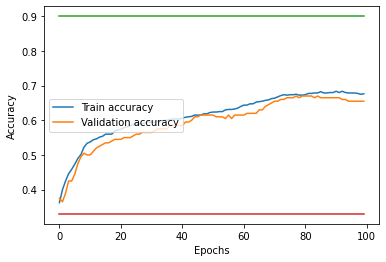

Training accuracy 0.6762
Validation accuracy 0.655


In [19]:
model = FFNetwork(init_method='he', activation_function='relu')
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

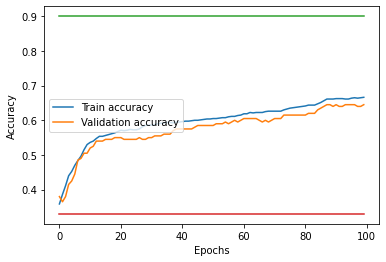

Training accuracy 0.6662
Validation accuracy 0.645


In [20]:
model = FFNetwork(init_method='he', activation_function='leaky_relu')
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

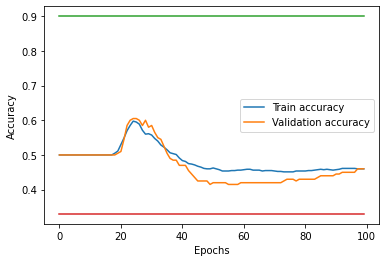

Training accuracy 0.46
Validation accuracy 0.46


In [21]:
model = FFNetwork(init_method='xavier', activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

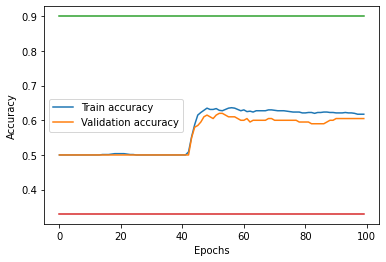

Training accuracy 0.6175
Validation accuracy 0.605


In [22]:
model = FFNetwork(init_method='xavier', activation_function='tanh')
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

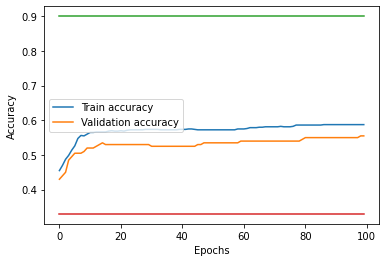

Training accuracy 0.5875
Validation accuracy 0.555


In [23]:
model = FFNetwork(init_method='xavier', activation_function='relu')
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

C:\Users\USER\AppData\Local\Temp/ipykernel_6628/2933390867.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/100 [00:00<?, ?epoch/s]

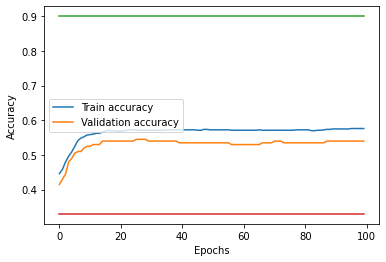

Training accuracy 0.5762
Validation accuracy 0.54


In [24]:
model = FFNetwork(init_method='xavier', activation_function='leaky_relu')
model.fit(X_train, y_OH_train, epochs=100, eta=0.1)
print_accuracy()

## So The combination of "he" with "relu" is giving highest accuracy so this is the best combination